In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
# Change file path to location of image folder
filePath = "5307Project2/"

In [ ]:
# Set up dataset
our_data_simple = ImageFolder(filePath, 
                              transform=transforms.Compose(
                                  [transforms.Resize((256,256)),
                                   transforms.RandomHorizontalFlip(0.2),
                                   transforms.RandomRotation(90),
                                   transforms.ToTensor()]), 
                              target_transform=None)

testSize = 704 # 20% of the original
valSize = 352
trainSize = len(our_data_simple) - testSize - valSize

# Split data into test and train sets
testset, trainset, valset = torch.utils.data.random_split(our_data_simple, [testSize, trainSize,valSize])

testloader = DataLoader(testset, batch_size=1, shuffle=True)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
valloader = DataLoader(valset, batch_size=1, shuffle=True)

In [ ]:
from torchvision.models import *
from IPython import display
net = resnet18().cuda()
net.train()
display.clear_output(wait=True)

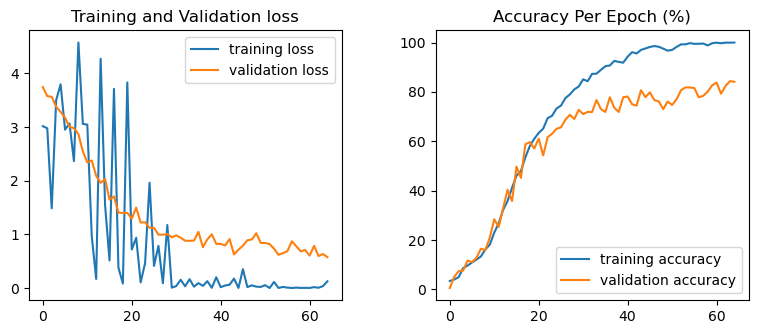

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test_and_train_loss(result_array):
  
  # functions to show the loss and precision
  # Its a bit more complicated to help with part 2
  fig, axs = plt.subplots(nrows=len(result_array), ncols=2, figsize=(8, 3 * len(result_array)))

  # For a single graph
  if len(result_array) == 1:
    training_loss_data, validation_loss_data, val_acc_data, train_acc_data= result_array[0]

    # Plot loss on first graph
    axs[0].plot(training_loss_data, label = "training loss")
    axs[0].set_title('Training and Validation loss')
    axs[0].plot(validation_loss_data, label = "validation loss")
    axs[0].legend()

    # Plot accuracy on second graph
    axs[1].plot(train_acc_data, label = "training accuracy")
    axs[1].plot(val_acc_data, label = "validation accuracy")
    axs[1].set_title("Accuracy Per Epoch (%)")
    axs[1].legend()

  else:
    for i in range(len(result_array)):
      training_loss_data, validation_loss_data, val_acc_data, train_acc_data = result_array[i]

      # Plot loss on first graph
      axs[i][0].plot(training_loss_data, label = "training loss")
      axs[i][0].set_title('Training and Validation loss')
      axs[i][0].plot(validation_loss_data, label = "validation loss")
      axs[i][0].legend()

      # Plot accuracy on second graph
      axs[i][1].plot(train_acc_data, label = "training accuracy")
      axs[i][1].plot(val_acc_data, label = "validation accuracy")
      axs[i][1].set_title("Accuracy Per Epoch (%)")
      axs[i][1].legend()

  plt.subplots_adjust(left=0.05, bottom=0.05,right=0.95,top=0.95,wspace=0.3,hspace=0.3)
  plt.show()

#plot_test_and_train_loss([[training_loss_data, validation_loss_data, val_acc_per_epoch, train_acc_per_epoch]])

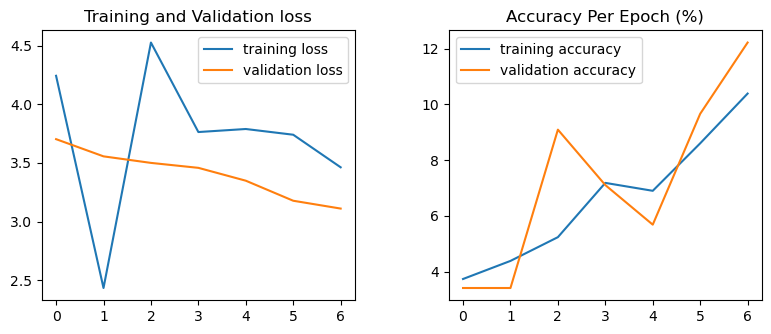

In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Setup variables for plotting loss and accuracy
training_loss_data = []
validation_loss_data = []
val_acc_per_epoch = []
train_acc_per_epoch = []

# This is used to calculate the accuracy of the network on a dataloader
def cal_precision(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images = data[0].cuda()
            labels = data[1].cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100


def cal_val_loss(net, valloader):

  running_loss = 0.0
  for i, data in enumerate(valloader, 0):
    # get the inputs // and add GPU mode
    inputs = data[0].cuda()
    labels = data[1].cuda()
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

  return running_loss / len(valloader)


for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs // and add GPU mode
        inputs = data[0].cuda()
        labels = data[1].cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #Calculate Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # End of Epoch
    # Save data for loss and accuracy
    training_loss_data.append(loss.item())
    train_acc_per_epoch.append(correct / total * 100)
    validation_loss_data.append(cal_val_loss(net, valloader))
    val_acc_per_epoch.append(cal_precision(net, valloader))
    display.clear_output(wait=True)
    plot_test_and_train_loss([[training_loss_data, validation_loss_data, val_acc_per_epoch, train_acc_per_epoch]])

display.clear_output(wait=True)

print('Finished Training')

In [ ]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images = data[0].cuda()
            labels = data[1].cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return 100 * correct / total

Accuracy of the network on the 10000 test images: 84 %


84.6590909090909

In [ ]:
# Final Plot
plot_test_and_train_loss([[training_loss_data, validation_loss_data, val_acc_per_epoch, train_acc_per_epoch]])

# Final Accuracy
eval_net(net, testloader)

In [ ]:
#Save Network
torch.save(net.state_dict(), "network.pth")